In [3]:
!pip install catboost seaborn kagglehub imbalanced-learn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


# Fraud Detection using CatBoost

In [4]:
import random
from pathlib import Path

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

sns.set_theme(style="whitegrid", palette="pastel")

## Load

In [5]:
path = Path(kagglehub.dataset_download("jainilcoder/online-payment-fraud-detection"))
df = pl.read_csv(path / "onlinefraud.csv")
print(df.shape)
print(df.columns)
print(df.dtypes)

100%|██████████| 178M/178M [00:01<00:00, 113MB/s]

Extracting files...


(6362620, 11)
['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
[Int64, String, Float64, String, Float64, Float64, String, Float64, Float64, Int64, Int64]


In [6]:
# Rename column due to typo I guess
df = df.rename({"oldbalanceOrg": "oldbalanceOrig"})
print(df.columns)

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [7]:
df.head()

step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
i64,str,f64,str,f64,f64,str,f64,f64,i64,i64
1,"""PAYMENT""",9839.64,"""C1231006815""",170136.0,160296.36,"""M1979787155""",0.0,0.0,0,0
1,"""PAYMENT""",1864.28,"""C1666544295""",21249.0,19384.72,"""M2044282225""",0.0,0.0,0,0
1,"""TRANSFER""",181.0,"""C1305486145""",181.0,0.0,"""C553264065""",0.0,0.0,1,0
1,"""CASH_OUT""",181.0,"""C840083671""",181.0,0.0,"""C38997010""",21182.0,0.0,1,0
1,"""PAYMENT""",11668.14,"""C2048537720""",41554.0,29885.86,"""M1230701703""",0.0,0.0,0,0


## EDA

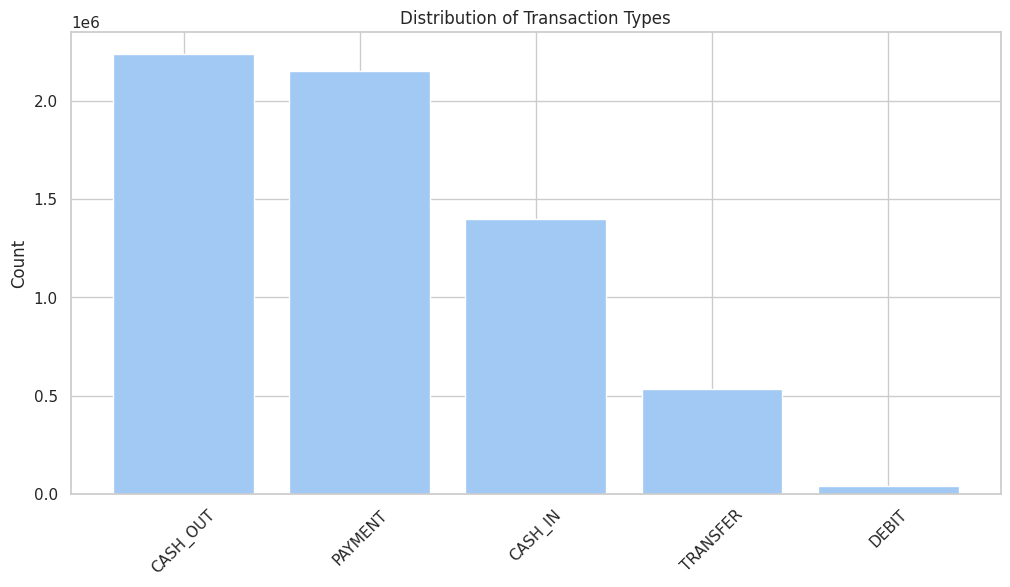

In [8]:
type_counts = df.group_by('type').agg(pl.len()).sort('len', descending=True)

plt.figure(figsize=(12, 6))
plt.bar(type_counts['type'].to_list(), type_counts['len'].to_list())
plt.title('Distribution of Transaction Types')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

Diffs in balance after transactions in case of frauds on supervised data

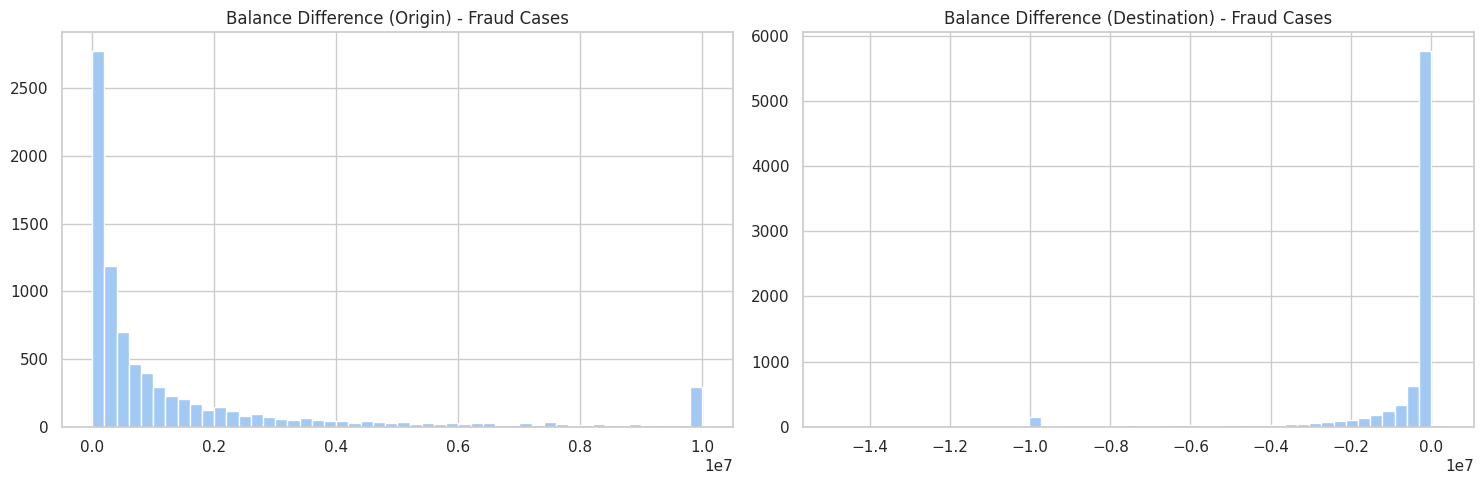

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
df = df.with_columns([
    (pl.col('oldbalanceOrig') - pl.col('newbalanceOrig')).alias('balance_diff_org')
])
fraud_diff_org = df.filter(pl.col('isFraud') == 1)['balance_diff_org'].to_numpy()
plt.hist(fraud_diff_org, bins=50)
plt.title('Balance Difference (Origin) - Fraud Cases')

plt.subplot(1, 2, 2)
df = df.with_columns([
    (pl.col('oldbalanceDest') - pl.col('newbalanceDest')).alias('balance_diff_dest')
])
fraud_diff_dest = df.filter(pl.col('isFraud') == 1)['balance_diff_dest'].to_numpy()
plt.hist(fraud_diff_dest, bins=50)
plt.title('Balance Difference (Destination) - Fraud Cases')

plt.tight_layout()
plt.show()

## Preprocess data

In [10]:
le = LabelEncoder()
df = df.with_columns([
    pl.Series(name='type_encoded', values=le.fit_transform(df['type'].to_numpy()))
])

features = ['type_encoded', 'amount', 'oldbalanceOrig', 'newbalanceOrig',
           'oldbalanceDest', 'newbalanceDest']
X = df[features].to_numpy()
y = df['isFraud'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=SEED)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Original training set shape:", np.bincount(y_train))
print("Balanced training set shape:", np.bincount(y_train_balanced))

Original training set shape: [5083503    6593]
Balanced training set shape: [5083503 5083503]


## Train CatBoost Model

In [12]:
model = CatBoostClassifier(
    iterations=500,
    random_seed=SEED,
    verbose=100
)

model.fit(X_train_balanced, y_train_balanced)

Learning rate set to 0.5
0:	learn: 0.1340892	total: 2.23s	remaining: 18m 31s
100:	learn: 0.0098529	total: 4m 2s	remaining: 15m 59s
200:	learn: 0.0080499	total: 7m 33s	remaining: 11m 13s
300:	learn: 0.0077361	total: 10m 39s	remaining: 7m 2s
400:	learn: 0.0077361	total: 13m 42s	remaining: 3m 23s
499:	learn: 0.0067563	total: 16m 53s	remaining: 0us


In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.34      1.00      0.50      1620

    accuracy                           1.00   1272524
   macro avg       0.67      1.00      0.75   1272524
weighted avg       1.00      1.00      1.00   1272524



## Save the Model

In [14]:
import pickle

path_to_artifact = Path('../artifacts/00_boosting/')

model.save_model(path_to_artifact / 'fraud_detection_model.cbm')

with open(path_to_artifact / 'metadata.pkl', 'wb') as f:
    pickle.dump({
        'features': features,
        'label_encoder': le
    }, f)